# Aspect Category Detection (ACD)

- POS-based Frequency Analysis: Surfaces dominant nouns and proper nouns
- Topic Modelling (LDA): Identifies latent themes across documents
- k-means Clustering: Groups semantically similar terms 


## Data Cleaning and Preprocessing

for the columns in the dataframe that contain text.

reviews_df:
- headline
- pro 
- contra
- patient_review




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter
import spacy

from nltk.stem import SnowballStemmer
from nltk.stem.snowball import GermanStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

import seaborn as sns

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser

In [2]:
# Read review CSV
patient_review_df = pd.read_csv("data/sentence_data/patient_review_sentences.csv", sep=",")

r, c = patient_review_df.shape
print(f"The review data has {r} rows and {c} columns")

headline_df = pd.read_csv("data/sentence_data/headline_sentences.csv", sep=",")
r, c = headline_df.shape
print(f"The headline data has {r} rows and {c} columns")

pro_df = pd.read_csv("data/sentence_data/pro_sentences.csv", sep=",")
r, c = pro_df.shape
print(f"The pro data has {r} rows and {c} columns")

contra_df = pd.read_csv("data/sentence_data/contra_sentences.csv", sep=",")
r, c = contra_df.shape
print(f"The contra data has {r} rows and {c} columns")


The review data has 4678 rows and 2 columns
The headline data has 497 rows and 2 columns
The pro data has 397 rows and 2 columns
The contra data has 341 rows and 2 columns


In [3]:
# function for cleaning text
def clean_text(text):
    """
    Returns the cleaned text

    Parameters:
    text (string): input text

    Returns:
    text (string): cleaned text
    """
    accent_mapping = pd.DataFrame({
        'Original': ["ä", "ö", "ü", "ß", "é", "è", "à", "å", "ê", "î", "ô", "ù", "ç", "á", "ì", "í", "ò", "ó", "ú"],
        'Replacement': ["ae", "oe", "ue", "ss", "e", "e", "a", "a", "e", "i", "o", "u", "c", "a", "i", "i", "o", "o", "u"]
        })
    if isinstance(text, str):
        # Remove special characters and punctuation
        text = re.sub(r'[^a-zA-Z0-9äöüÄÖÜß\s]', ' ', text)
        # Convert to lowercase
        text = text.lower()
        # Replace accented vowels in German text
        for original, replacement in zip(accent_mapping['Original'], accent_mapping['Replacement']):
            text = text.replace(original, replacement)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
    return text


In [4]:
# Cleaning and normalization with POS tags

# Load spaCy's German model
nlp = spacy.load("de_core_news_sm")

# Load German stopwords
stopwords_de = set(stopwords.words('german'))
stopwords_de2 = pd.read_table("data/de_complete.txt", header=None)[0].tolist()  # External stopwords list
stopwords_custom = []  # Add any additional custom stopwords here
combined_stopwords = list(dict.fromkeys(stopwords_de.union(stopwords_de2 + stopwords_custom)))
negation_words = {"nicht", "kein", "keine", "keinen", "keinem", "keiner", "keines", "nie", "ohne", "weder", "noch"}  # Negation words
filtered_stopwords = [word for word in combined_stopwords if word not in negation_words]
filtered_stopwords = set(filtered_stopwords)  # Convert to set for faster lookup

lemmatizer = WordNetLemmatizer()

# Accent mapping for German characters
accent_mapping = pd.DataFrame({
    'Original': ["ä", "ö", "ü", "ß", "é", "è", "à", "å", "ê", "î", "ô", "ù", "ç", "á", "ì", "í", "ò", "ó", "ú"],
    'Replacement': ["ae", "oe", "ue", "ss", "e", "e", "a", "a", "e", "i", "o", "u", "c", "a", "i", "i", "o", "o", "u"]
})

# Function to clean, normalize, and tag text while preserving POS information
def clean_text_with_pos(text):
    """
    Processes text: applies POS tagging, lemmatization, stopword removal, and accent normalization.

    Parameters:
    text (string): input text

    Returns:
    list of tuples: List of (lemmatized_token, pos) tuples for the cleaned text
    """
    # Apply POS tagging
    doc = nlp(text)
    
    cleaned_tokens = []
    for token in doc:
        # Normalize accented characters
        token_text = token.text
        for original, replacement in zip(accent_mapping['Original'], accent_mapping['Replacement']):
            token_text = token_text.replace(original, replacement)
        
        # Convert to lowercase, remove special characters, and check if it's a stopword
        token_text = re.sub(r'[^a-zA-Z0-9äöüÄÖÜß\s]', '', token_text).lower()
        if token_text in filtered_stopwords or not token_text.strip():
            continue  # Skip stopwords and empty tokens
        
        # Apply lemmatization
        # lemma = lemmatizer.lemmatize(token_text)
        lemma = token.lemma_  # Use spaCy's lemma

        # Append the cleaned, lemmatized token and its POS tag
        cleaned_tokens.append((lemma, token.pos_))
    
    return cleaned_tokens


Get the text again after adding a POS-Tag to each word in the dataset

In [5]:
# Function to convert (token, POS) tuples to a single tokenized string for single or multiple documents
def get_text(documents):
    """
    Converts a list of (token, POS) tuples to a single tokenized string, or a list of such strings for multiple documents.

    Parameters:
    documents (list of tuples or list of lists of tuples): A document (list of (token, POS) tuples)
        or multiple documents (list of lists of (token, POS) tuples).

    Returns:
    str or list of str: Tokenized string(s), one per document if multiple documents were provided, ready for LDA input.
    """
    # Helper function to join tokens for a single document
    def join_tokens(document):
        return " ".join([token for token, pos in document])

    # Check if the input is a single document or multiple documents
    if isinstance(documents[0], tuple):
        # Single document case
        return join_tokens(documents)
    elif isinstance(documents[0], list):
        # Multiple documents case
        return [join_tokens(doc) for doc in documents]
    else:
        raise ValueError("Input should be a list of tuples or list of lists of tuples.")

# Function to filter text based on POS tags for single or multiple documents
def get_text_by_pos(documents, pos_filters=["NOUN", "VERB", "PROPN"]):
    """
    Filters tokens by a list of POS tags and returns text for topic modeling.

    Parameters:
    documents (list of tuples or list of lists of tuples): A document (list of (token, POS) tuples)
        or multiple documents (list of lists of (token, POS) tuples).
    pos_filters (list of str): List of POS tags to keep, e.g., ["NOUN", "VERB", "PROPN"].

    Returns:
    list of str: List of tokenized and filtered text for each document, or a single string if a single document was provided.
    """
    pos_filters = set(pos_filters)  # Convert pos_filters to set for efficient lookup

    # Helper function to filter tokens for a single document
    def filter_tokens(document):
        return " ".join([token for token, pos in document if pos in pos_filters])

    # Check if the input is a single document or multiple documents
    if isinstance(documents[0], tuple):
        # Single document case
        return filter_tokens(documents)
    elif isinstance(documents[0], list):
        # Multiple documents case
        return [filter_tokens(doc) for doc in documents]
    else:
        raise ValueError("Input should be a list of tuples or list of lists of tuples.")


In [6]:
# if needed replace NaN values with empty strings in the relevant columns
patient_review_df["sentence"] = patient_review_df["sentence"].fillna("").astype(str)
headline_df["sentence"] = headline_df["sentence"].fillna("").astype(str)
pro_df["sentence"] = pro_df["sentence"].fillna("").astype(str)
contra_df["sentence"] = contra_df["sentence"].fillna("").astype(str)

In [7]:
# Apply the cleaning function with POS Tagging to each column
headline_df["sentence"] = headline_df["sentence"].apply(clean_text_with_pos)
pro_df["sentence"] = pro_df["sentence"].apply(clean_text_with_pos)
contra_df["sentence"] = contra_df["sentence"].apply(clean_text_with_pos)
patient_review_df["sentence"] = patient_review_df["sentence"].apply(clean_text_with_pos)


#### Handling negations

Words like "not" can change the meaning of a sentence. i want to consider preprocessing phrases like "not good" to "not_good" to retain the negation's influence.

In [8]:
# Define German Negation Words
negation_words = {'nicht', 'kein', 'keine', 'keinen', 'keinem', 'keiner', 'niemals', 'nie', 'nichts', 'ohne', 'weder', 'noch'}

# Define the function to handle negations with prioritized adjective, proper noun, and adverb checks
def handle_negations_with_prioritized_pos(doc, negation_words=negation_words):
    """
    Processes a list of (token, pos) tuples to handle negations by combining
    negation words with an adjective, proper noun, or adverb (in priority order)
    within the next three tokens.

    Parameters:
    doc (list of tuples): List of (token, POS) tuples.
    negation_words (set): Set of negation words in German.

    Returns:
    str: Processed sentence with negations combined with following adjectives/proper nouns/adverbs within a three-word window.
    """
    processed_tokens = []
    i = 0  # Iterator index

    # Iterate over tokens in the document
    while i < len(doc):
        token, pos = doc[i]
        
        # Check if the token is a negation word
        if token.lower() in negation_words:
            neg_word = token
            combined = False
            target_word = None

            # Step 1: Look for an adjective (ADJ) in the next three tokens
            for j in range(1, 4):
                if i + j < len(doc):  # Ensure we don't go out of bounds
                    next_token, next_pos = doc[i + j]
                    if next_pos == 'ADJ':  # Check if the word is an adjective
                        target_word = next_token
                        combined = True
                        i += j  # Move the index to skip the combined words
                        break
            
            # Step 2: If no adjective was found, look for a proper noun (PROPN)
            if not combined:
                for j in range(1, 4):
                    if i + j < len(doc):
                        next_token, next_pos = doc[i + j]
                        if next_pos == 'PROPN':  # Check if the word is a proper noun
                            target_word = next_token
                            combined = True
                            i += j
                            break
            
            # Step 3: If neither an adjective nor a proper noun was found, look for an adverb (ADV)
            if not combined:
                for j in range(1, 4):
                    if i + j < len(doc):
                        next_token, next_pos = doc[i + j]
                        if next_pos == 'ADV':  # Check if the word is an adverb
                            target_word = next_token
                            combined = True
                            i += j
                            break
            
            # Combine negation with the identified word, if found
            if combined:
                combined_word = f"{neg_word}_{target_word}"
                processed_tokens.append(combined_word)
            else:
                # If no matching POS is found, add the negation word as is
                processed_tokens.append(neg_word)
        else:
            # Add the current token as is if no combination occurs
            processed_tokens.append(token)
        
        # Move to the next token
        i += 1
    
    # Join processed tokens into a sentence
    return ' '.join(processed_tokens)


### 1. Extract Aspects using POS-Tagging

In [9]:
# merge frequency lists

def freq_list(nouns_all, noun_freq_df):
    """
    Merge and sum frequency lists for nouns.

    Parameters:
    nouns_all (DataFrame): DataFrame containing nouns and their frequencies in one dataset, with columns 'noun' and 'frequency'.
    noun_freq_df (DataFrame): DataFrame containing nouns and their frequencies in another dataset, with columns 'noun' and 'frequency'.

    Returns:
    final_df (DataFrame): DataFrame with combined nouns and their summed frequencies across both input datasets, with columns 'noun' and 'frequency'.
    """

    combined_df = pd.merge(nouns_all, noun_freq_df, on ="noun", how = "outer", suffixes=('_df1', '_df2'))
    # Fill NaN values with 0 for summation
    combined_df = combined_df.fillna(0)
    # Sum the frequencies
    combined_df['frequency'] = combined_df['frequency_df1'] + combined_df['frequency_df2']
    # Select the final DataFrame with only 'noun' and summed 'frequency'
    final_df = combined_df[['noun', 'frequency']]

    return final_df

In [10]:
nouns_all =  pd.DataFrame({'noun': [], 'frequency':[]})

# Prepare a dictionary of datasets to cluster and analyze
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df
}

# Process and count noun frequencies for each column
for dataname, dataset in datasets.items():
    # Extract nouns for each document in the column using `get_text_by_pos`
    nouns = get_text_by_pos(dataset["sentence"], ["NOUN", "PROPN"])  # Process reviews for topic modeling
    
    # Flatten list of nouns from all reviews
    all_nouns = [noun for doc in nouns for noun in doc.split()]
    
    # Count frequency of each noun
    noun_freq = Counter(all_nouns)
    
    # Convert to DataFrame for better visualization
    noun_freq_df = pd.DataFrame(noun_freq.items(), columns=['noun', 'frequency']).sort_values(by='frequency', ascending=False)
    
    # Merge current frequencies with the overall frequencies
    nouns_all = freq_list(nouns_all, noun_freq_df)
    
    # Display the most common nouns for the current column
    print(f"Most common nouns in {dataname}:") 
    print(noun_freq_df.head(20))  # Display top 20 frequent nouns for each column
    print()

# Display the most common nouns from all texts combined
print("\nMost common nouns across ALL datasets (combined):")
print(nouns_all.sort_values('frequency', ascending=False).head(20))  # Display top 20 frequent nouns overall

Most common nouns in patient_review:
           noun  frequency
0          Arzt        372
162          OP        268
83          Tag        255
57      Patient        253
58       Klinik        230
174   Schwester        230
98      Station        188
392      Stunde        138
97         Zeit        132
113     Leipzig        119
169   Uniklinik        114
27      Schmerz        112
759        Kind        106
99     Personal        103
65   Behandlung         96
54        Woche         95
180        Haus         91
218         Uhr         91
107        Jahr         86
52       Termin         85

Most common nouns in headline:
            noun  frequency
4     Behandlung         19
63        Klinik         17
16       Patient         14
41            OP         12
28         Danke         12
91     Betreuung         11
31          Arzt         11
221     Personal         10
55       Leipzig          9
140          Uni          8
94     Wartezeit          8
146       Geburt          8


In [14]:
# Initialize
nouns_all = pd.DataFrame({'noun': [], 'frequency': []})
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df
}

# Step 1: Collect all sentences to train bigram model
all_sentences = []
for dataset in datasets.values():
    sentences = [doc.split() for doc in get_text_by_pos(dataset["sentence"], ["NOUN", "PROPN"])]
    all_sentences.extend(sentences)

# Train bigram detector
bigram_model = Phrases(all_sentences, min_count=5, threshold=10)  # Adjust thresholds
bigram_phraser = Phraser(bigram_model)

# Step 2: Process each dataset with bigrams
for dataname, dataset in datasets.items():
    # Extract nouns and apply bigrams
    tokenized_texts = [doc.split() for doc in get_text_by_pos(dataset["sentence"], ["NOUN", "PROPN"])]
    texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts if doc]  # Apply bigrams
    
    # Flatten and count frequencies (now includes bigrams)
    all_nouns = [term for doc in texts_with_bigrams for term in doc]
    noun_freq = Counter(all_nouns)
    
    # Convert to DataFrame
    noun_freq_df = pd.DataFrame(noun_freq.items(), columns=['noun', 'frequency'])
    
    # Merge with global frequencies
    nouns_all = freq_list(nouns_all, noun_freq_df)
    
    # Print top terms (now includes bigrams)
    print(f"Top nouns + bigrams in {dataname}:")
    print(noun_freq_df.sort_values('frequency', ascending=False).head(20))
    print()

# Global results
print("Top nouns + bigrams across ALL datasets:")
print(nouns_all.sort_values('frequency', ascending=False).head(20))

Top nouns + bigrams in patient_review:
           noun  frequency
0          Arzt        372
162          OP        268
83          Tag        255
57      Patient        249
58       Klinik        230
174   Schwester        205
98      Station        188
393      Stunde        138
97         Zeit        132
27      Schmerz        112
764        Kind        106
99     Personal        103
65   Behandlung         96
54        Woche         95
219         Uhr         91
180        Haus         91
107        Jahr         86
52       Termin         85
4        Zimmer         84
194   Uniklinik         82

Top nouns + bigrams in headline:
            noun  frequency
4     Behandlung         19
61        Klinik         17
16       Patient         12
41            OP         12
28         Danke         12
31          Arzt         11
89     Betreuung         11
221     Personal         10
92     Wartezeit          8
146       Geburt          8
168   Entbindung          8
139          Uni        

/tmp/ipykernel_669268/543232776.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='noun', data=noun_freq_df.head(20), palette='viridis')


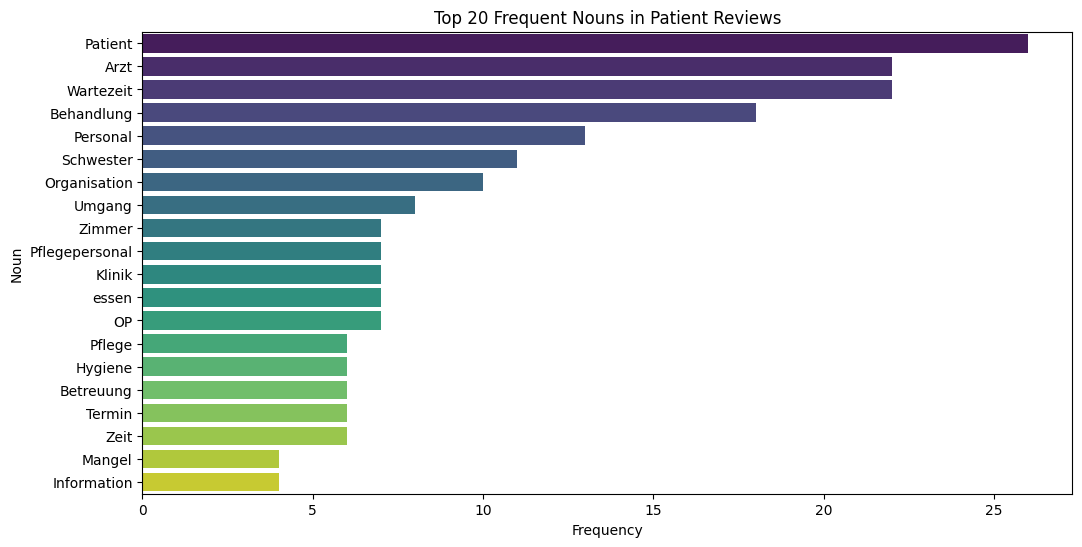

In [11]:
# Plot the top 20 nouns
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='noun', data=noun_freq_df.head(20), palette='viridis')
plt.title('Top 20 Frequent Nouns in Patient Reviews')
plt.xlabel('Frequency')
plt.ylabel('Noun')
plt.show()

### 2. Aspect extraction with Topic Modeling - LDA

- patient_reviews
- headline
- pro
- contra

only using Nouns, Proper Nouns and Verbs for the analysis

In [9]:
#  function to derive the Jaccard similarity of two topics
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

# Topic Modeling
def topic_modelling(DTM, n_topics=20, alpha=0.1, iterations=500):
    """
    Perform topic modeling on a Document-Term Matrix (DTM) using Latent Dirichlet Allocation (LDA).

    Parameters:
    DTM (array-like or sparse matrix): Document-Term Matrix to use for training the LDA model.
    n_topics (int, optional): Number of topics to extract from the data. Default is 20.
    alpha (float, optional): Hyperparameter controlling topic distribution per document (currently unused but often set for further LDA tuning). Default is 0.1.
    iterations (int, optional): Maximum number of iterations for the LDA model training (currently unused in this function but can influence convergence). Default is 500.

    Returns:
    lda_model (LatentDirichletAllocation): Trained LDA model fitted to the input DTM, capturing specified topics.
    """
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=1)
    lda_model.fit(DTM)
    return lda_model

# Print the top terms for each topic
def print_top_terms(model, vectorizer, n_terms=10):
    """
    Display the top terms for each topic in a trained topic model.

    Parameters:
    model (LatentDirichletAllocation or similar): Trained topic model with accessible topic components.
    vectorizer (CountVectorizer or TfidfVectorizer): Fitted vectorizer used to transform text data, providing feature names.
    n_terms (int, optional): Number of top terms to display for each topic. Default is 10.

    Returns:
    None: Prints the top terms for each topic in the model, showing the most representative words per topic.
    """
    terms = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f'Topic {topic_idx}:', ', '.join([terms[i] for i in topic.argsort()[:-n_terms - 1:-1]]))

# Load the German language model
nlp = spacy.load("de_core_news_sm")


get optimal number of topics for LDA

using https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

Ideal Topic number for each column with free text:

ideal number of topics will maximize coherence and minimize the topic overlap based on Jaccard similarity.

/home/sc.uni-leipzig.de/ch31qoni/venv/py312_2/lib/python3.12/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/home/sc.uni-leipzig.de/ch31qoni/venv/py312_2/lib/python3.12/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


ideal number of topics for 'patient_review' that maximizes coherence and minimize topic overlap:  3
Alpha values for ideal number of topics (3): [0.21966581 0.11381038 0.11835001]
Eta values for ideal number of topics (3): [ 0.777123   10.59695     2.4279165  ...  0.3265832   0.32657194
  0.32656243]


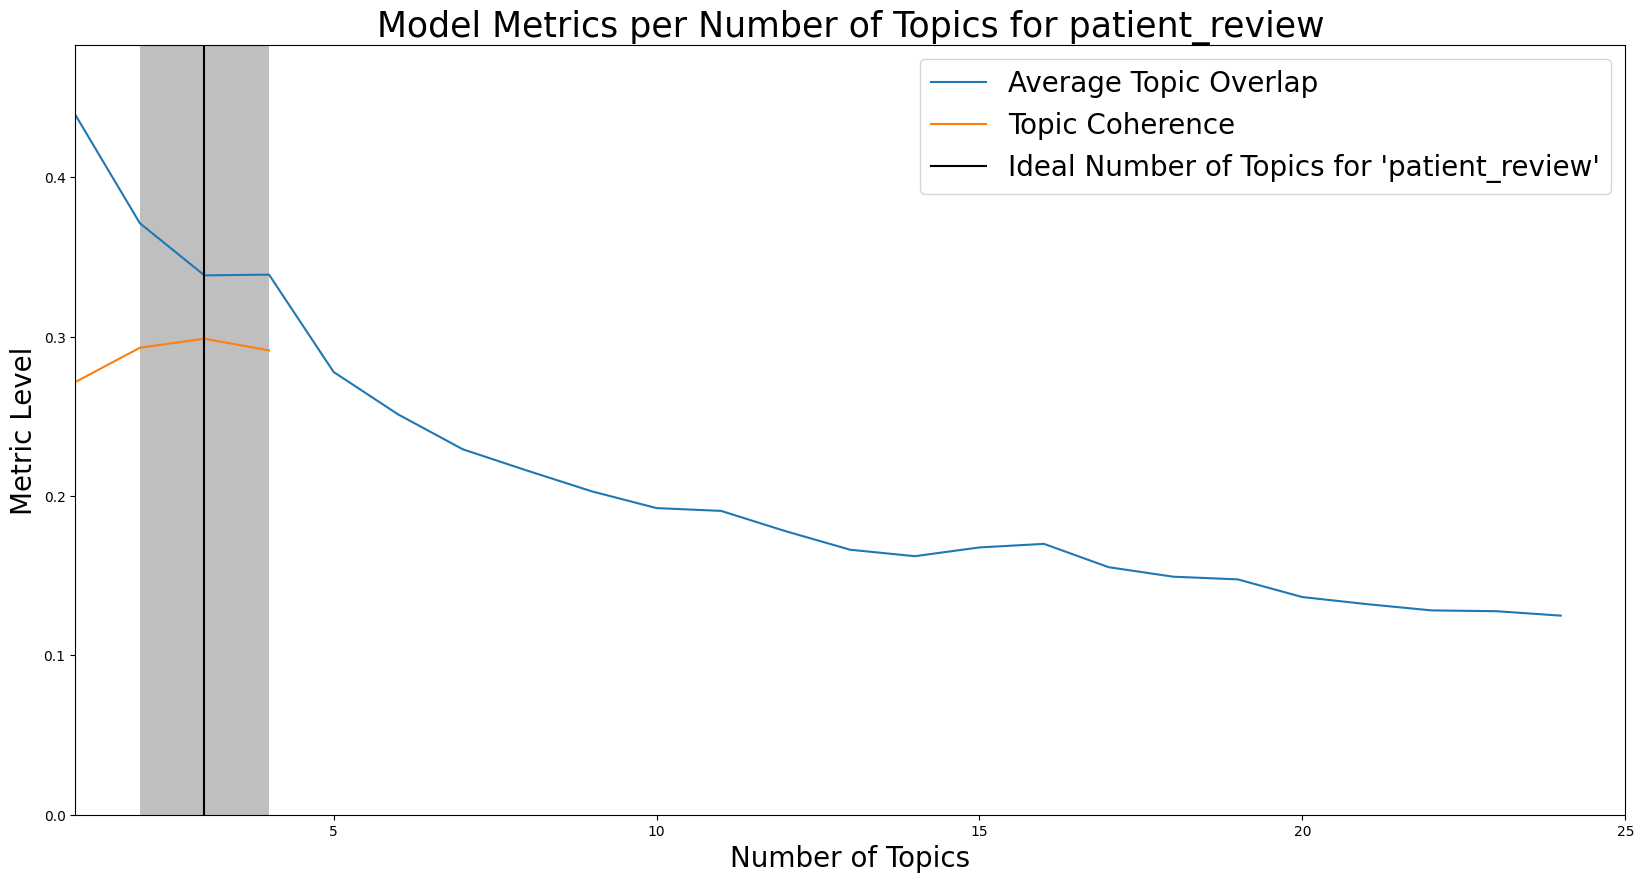

Results for patient_review saved successfully!
ideal number of topics for 'headline' that maximizes coherence and minimize topic overlap:  4
Alpha values for ideal number of topics (4): [0.1547066  0.19335556 0.17552024 0.19519737]
Eta values for ideal number of topics (4): [0.30311072 0.25733232 0.27035642 0.2573426  0.2573419  0.3555073
 0.2701958  0.2573413  0.25735348 0.25733778 0.2573358  0.2573471
 0.2702627  0.27807114 0.27867344 0.29172954 0.25734055 0.35845828
 0.25742075 0.32582462 0.2574147  0.25731823 0.25731727 0.2573184
 0.25742707 0.2573426  0.35732567 0.25743476 0.25730154 0.37056896
 0.25730285 0.2573011  0.35734972 0.48318148 0.2574351  0.25732055
 0.46796632 0.2573229  0.2573362  0.25742137 0.27800775 0.25731775
 0.33607417 0.2573278  0.47261277 0.2573476  0.46522802 0.25734168
 0.3572019  0.25731298 0.257306   0.25730836 0.25733835 0.28786555
 0.25731987 0.25731474 0.38111517 0.25734395 0.28437057 0.28508508
 0.25734022 0.25733933 0.7104647  0.27216858 0.38854197 0.

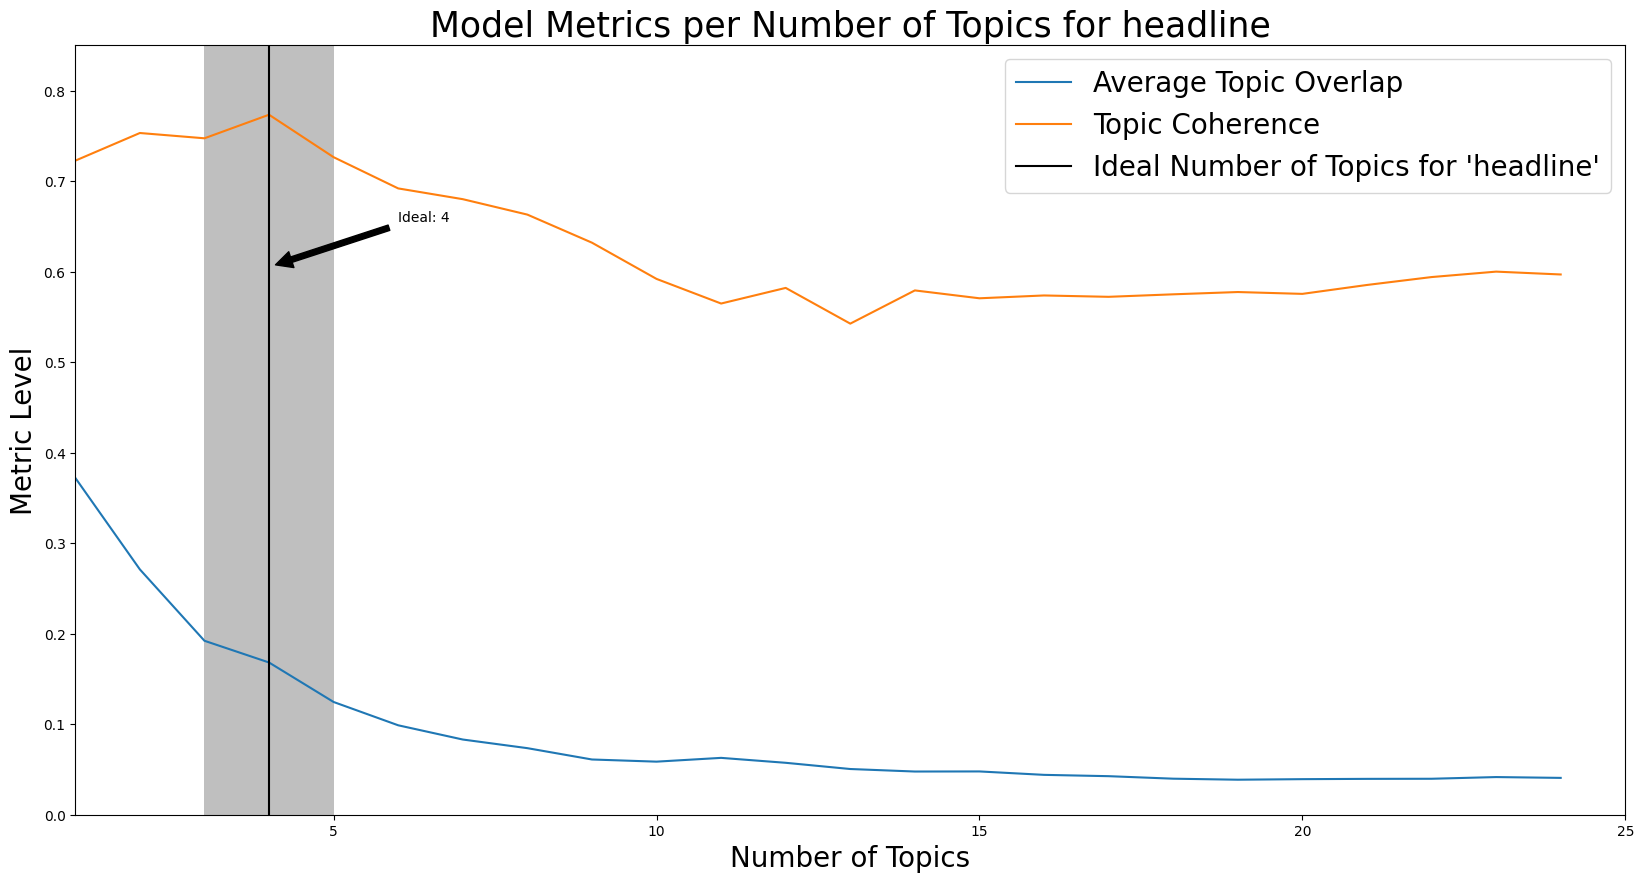

Results for headline saved successfully!
ideal number of topics for 'pro' that maximizes coherence and minimize topic overlap:  5
Alpha values for ideal number of topics (5): [0.14428991 0.13043368 0.13549434 0.1599075  0.16968785]
Eta values for ideal number of topics (5): [0.33093002 0.24343327 0.2392407  0.2529723  0.25299263 0.2543567
 0.24343073 0.19796956 0.20494786 0.20449008 0.20449394 0.19821522
 0.21184038 0.2049178  0.21102685 0.2085979  0.19794762 0.19794731
 0.42616645 0.19794725 0.19796887 0.19794998 0.20517725 0.19794913
 0.28798026 0.19796737 0.25376466 0.19796698 0.19796804 0.2049004
 0.19794789 0.20912315 0.70719296 0.35728952 0.25903383 0.19796999
 0.19796619 0.24342753 0.25297478 0.19794708 0.27043638 0.21078447
 0.197948   0.19794723 0.19794676 0.19794905 0.1979498  0.35769692
 0.24343063 0.20518167 0.48251185 0.2434163  0.20437762 0.19794539
 0.19794478 0.2043794  0.19967104 0.20436521 0.20489378 0.19797283
 0.19795401 0.19867176 0.2951278  0.21630825 0.25300044 0

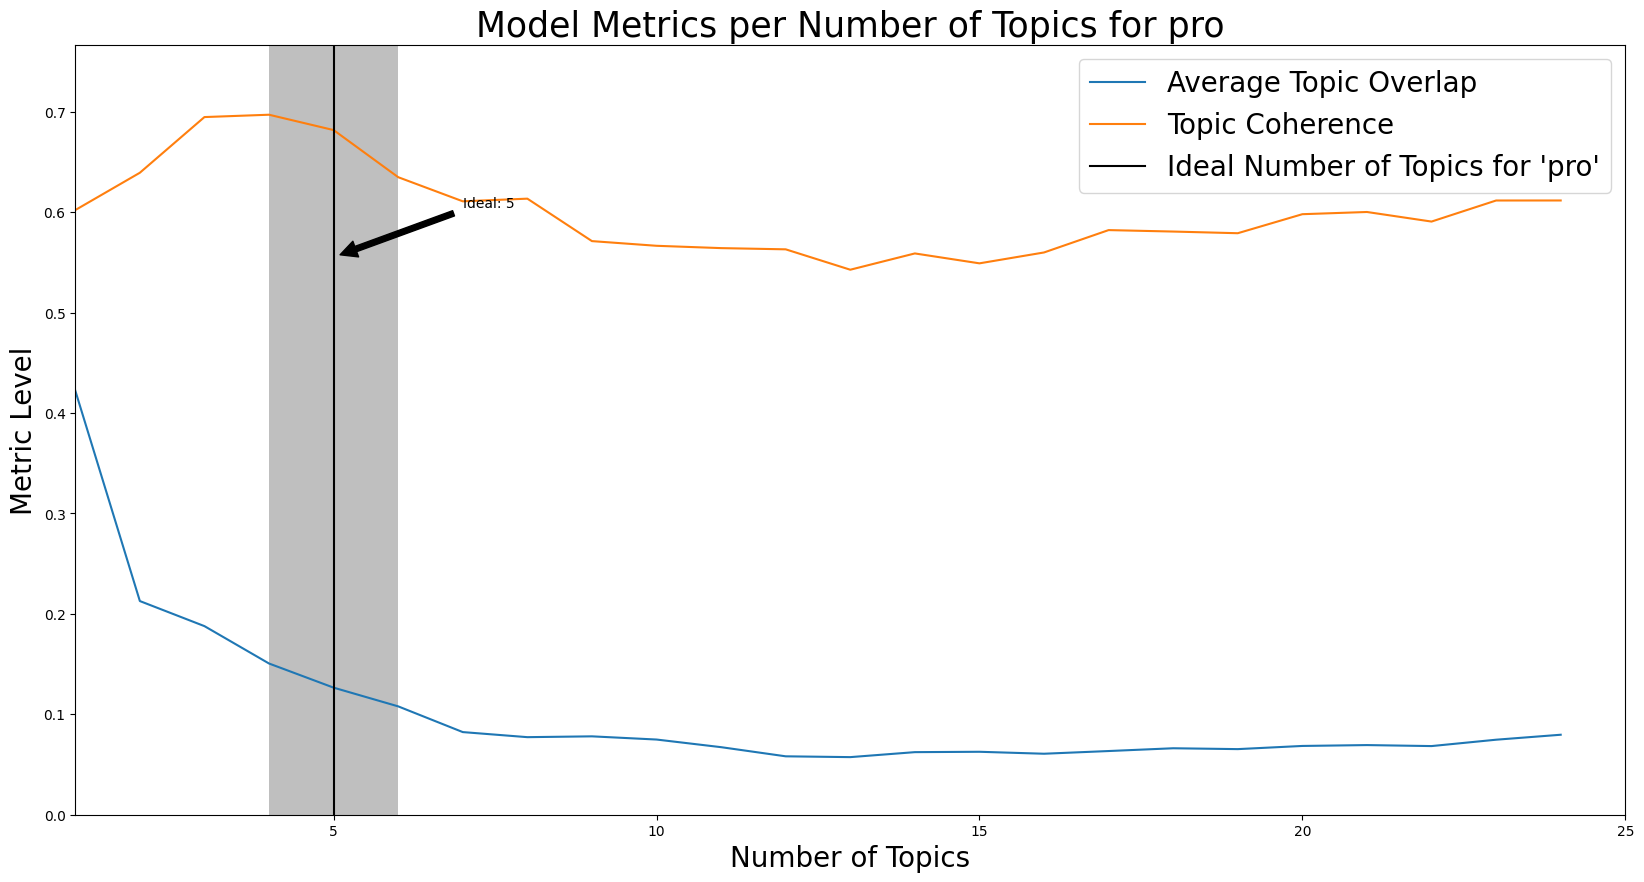

Results for pro saved successfully!
ideal number of topics for 'contra' that maximizes coherence and minimize topic overlap:  5
Alpha values for ideal number of topics (5): [0.10286633 0.14966592 0.13163513 0.12334291 0.11441723]
Eta values for ideal number of topics (5): [0.20461506 0.26967487 0.297636   0.26368803 0.211463   0.20463866
 0.263676   0.2046195  0.67959124 0.542561   0.21596923 0.2046167
 0.26381406 0.37227178 0.27211604 0.20461965 0.2046359  0.5686495
 0.2046206  0.20461676 0.30904222 0.20461665 0.20461655 0.20462365
 0.34104547 0.27053082 0.20462206 0.23117031 0.2748563  0.2533631
 0.20461483 0.25336042 0.23829207 0.20461603 0.20461555 0.2046167
 0.20461717 0.2120388  0.28968212 0.2046194  0.2046219  0.2938411
 0.20462056 0.3464552  0.20462161 0.21201846 0.20461847 0.20461936
 0.2046202  0.20462257 0.2114771  0.2533578  0.20461604 0.20461638
 0.20461696 0.20462357 0.20462015 0.20463093 0.2046336  0.20462276
 0.21596752 0.28313297 0.51430655 0.21201694 0.2046191  0.2046

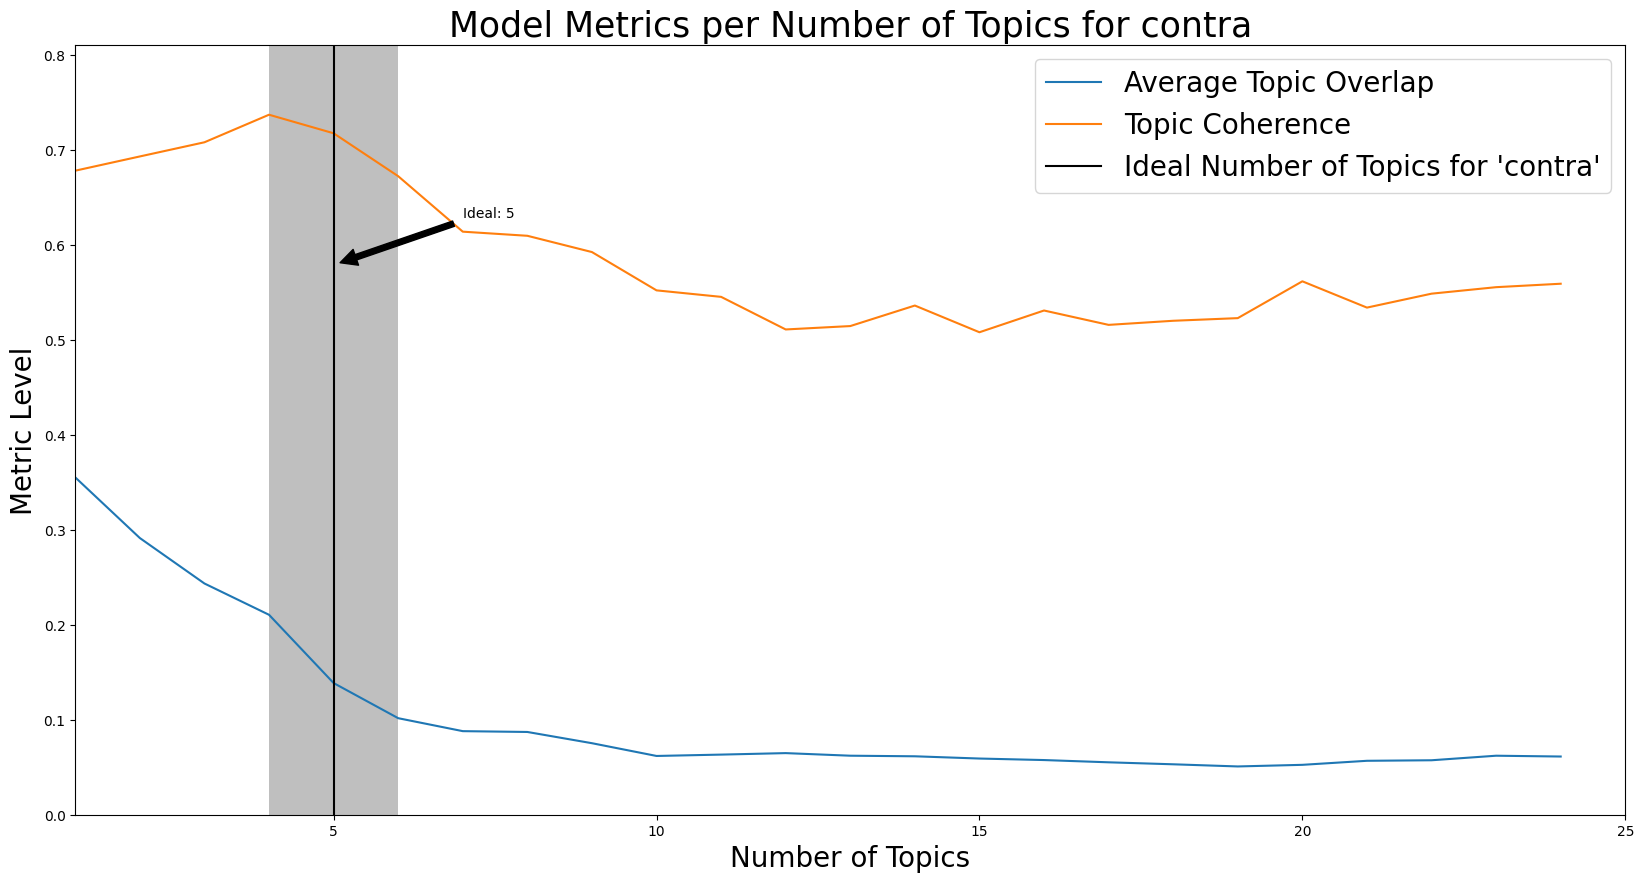

Results for contra saved successfully!
All results saved to lda_results.csv.
LDA results saved to lda_parameters.csv.


In [12]:
# Prepare a dictionary of datasets to cluster and analyze
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df
}

# results list to store findings for each column
all_results = []
lda_parameters = {}

# Loop over each dataset to fit LDA and print top terms
for dataname, dataset in datasets.items():
    # Create a dictionary and corpus for LDA topic number test
    texts = get_text_by_pos(dataset["sentence"])  # Process reviews for topic modeling
    # Tokenize each document by splitting on whitespace
    tokenized_texts = [text.split() for text in texts]

    # Create bigrams and trigrams
    bigram = Phrases(tokenized_texts, min_count=5, threshold=10)  # Higher threshold for fewer phrases
    # Apply the Phraser for efficiency
    bigram_mod = Phraser(bigram)
    # Transform texts to include bigrams and trigrams
    texts_with_bigrams = [bigram_mod[text] for text in tokenized_texts if text]

    # tokenized_texts = [text for text in tokenized_texts if text]

    dictionary = corpora.Dictionary(texts_with_bigrams) #tokenized_texts)
    dictionary.filter_extremes(no_below=0.01, no_above=0.9)  # Filter very rare and very frequent words
    corpus = [dictionary.doc2bow(doc) for doc in texts_with_bigrams] #tokenized_texts]

    # Considering 1-25 topics, as the last is cut off
    num_topics = list(range(26)[1:])
    num_keywords = 25

    LDA_models = {}
    LDA_topics = {}
    final_alpha = {}
    final_eta = {}
    for i in num_topics:
        LDA_models[i] = LdaModel(corpus=corpus,
                                id2word=dictionary,
                                num_topics=i,
                                update_every=1,
                                chunksize=len(corpus),
                                passes=20,
                                alpha='auto',  # Automatically adjusts alpha
                                eta='auto',    # Automatically adjusts beta
                                random_state=42)
        
        # Access the values of alpha and eta chosen by Gensim
        final_alpha[i] = LDA_models[i].alpha
        final_eta[i] = LDA_models[i].eta

        shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                                num_words=num_keywords,
                                                formatted=False)
        LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

    # derive the mean stability across topics by considering the next topic
    LDA_stability = {}
    for i in range(0, len(num_topics)-1):
        jaccard_sims = []
        for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
            sims = []
            for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
                sims.append(jaccard_similarity(topic1, topic2))    
            
            jaccard_sims.append(sims)    
        
        LDA_stability[num_topics[i]] = jaccard_sims
                    
    mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

    # built in model for topic coherence (this uses the 'c_v' option) 
    coherences = [CoherenceModel(model=LDA_models[i], texts=tokenized_texts, dictionary=dictionary, coherence='c_v').get_coherence() for i in num_topics[:-1]]

    # derive ideal number of topics roughly through difference between coherence and stability per number of topics:
    coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
    coh_sta_max = max(coh_sta_diffs)
    coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
    ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
    ideal_topic_num = num_topics[ideal_topic_num_index]

    # Save alpha and eta for the chosen number of topics
    chosen_alpha = final_alpha[ideal_topic_num]
    chosen_eta = final_eta[ideal_topic_num]

    # After determining the ideal topic number (ideal_topic_num), alpha, and eta for each column
    lda_parameters[dataname] = {
        "topics": ideal_topic_num,  # Ideal number of topics determined from the analysis
        "alpha": final_alpha[ideal_topic_num],  # Chosen alpha for the ideal number of topics
        "eta": final_eta[ideal_topic_num]   # Chosen eta for the ideal number of topics
    }

    # graph metrics across topic numbers:
    plt.figure(figsize=(20,10))
    ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
    ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')
    
    ax.axvline(x=ideal_topic_num, label=f"Ideal Number of Topics for '{dataname}'", color='black')
    ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

    # Annotate the ideal topic number
    plt.annotate(f"Ideal: {ideal_topic_num}", xy=(ideal_topic_num, coh_sta_max),
                 xytext=(ideal_topic_num + 2, coh_sta_max + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
    ax.set_ylim([0, y_max])
    ax.set_xlim([1, num_topics[-1]])

    print(f"ideal number of topics for '{dataname}' that maximizes coherence and minimize topic overlap: ", ideal_topic_num)
    # Print the alpha and eta values for the chosen number of topics
    print(f"Alpha values for ideal number of topics ({ideal_topic_num}): {final_alpha[ideal_topic_num]}")
    #print(f"Eta values for ideal number of topics ({ideal_topic_num}): {final_eta[ideal_topic_num]}")               
    
    ax.axes.set_title(f'Model Metrics per Number of Topics for {dataname}', fontsize=25)
    ax.set_ylabel('Metric Level', fontsize=20)
    ax.set_xlabel('Number of Topics', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()   

    # Save results for this column
    column_results = {
        'column': dataname,
        'ideal_topic_num': ideal_topic_num,
        'alpha': final_alpha[ideal_topic_num],
        'eta': final_eta[ideal_topic_num],
        'coherence': coherences,
        'stability': mean_stabilities,
    }
    all_results.append(column_results)

    # Save top words for each topic
    top_words = {}
    for topic_id, topic in enumerate(LDA_models[ideal_topic_num].show_topics(formatted=False, num_words=num_keywords)):
        top_words[f"Topic {topic_id}"] = [word[0] for word in topic[1]]

    with open(f'data/LDA/top_words_{dataname}.json', 'w') as f:
        json.dump(top_words, f, indent=4)

    print(f"Results for {dataname} saved successfully!")

# Save all column results to CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv('data/LDA/lda_results.csv', index=False)
print("All results saved to lda_results.csv.")
# Save all column results to CSV
lda_results_df = pd.DataFrame(lda_parameters)
lda_results_df.to_csv('data/LDA/lda_parameters.csv', index=False)
print("LDA results saved to lda_parameters.csv.")

### Best Number of Topics for LDA (Latent Dirichlet Allocation) topic modeling

|            | patient_review | headline | pro | contra |
|------------|----------------|----------|-----|--------|
| No. Topics | 3             | 4        | 5   | 5      |

In [10]:
# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, ngram_range=(1, 2)) # Create DTM, all words that occur in 1% to 90% of the documents
text = get_text_by_pos(patient_review_df['sentence'])  # Process reviews for topic modeling
DTM = vectorizer.fit_transform(text)

# Perform topic modeling
lda_model = topic_modelling(DTM, n_topics=3)

# Print top terms for each topic
print_top_terms(lda_model, vectorizer)

Topic 0: arzt, op, kommen, tag, bekommen, sagen, zeit, stunde, personal, fühlen
Topic 1: schwester, gehen, leipzig, uniklinik, behandeln, machen, uhr, haus, lassen, essen
Topic 2: patient, klinik, station, geben, schmerz, behandlung, jahr, zimmer, empfehlen, laufen


In [12]:
# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, ngram_range=(1, 2)) # Create DTM, all words that occur in 1% to 90% of the documents
text = get_text_by_pos(headline_df['sentence'])
DTM = vectorizer.fit_transform(text)

# Perform topic modeling
lda_model = topic_modelling(DTM, n_topics=4)

# Printing top terms for each topic
print_top_terms(lda_model, vectorizer)

Topic 0: danke, arzt, personal, geburt, uni, entbindung, notaufnahme, schwester, beratung, top
Topic 1: op, klinik, patient, wartezeit, beratung, mensch, team, arzt, top, hüft
Topic 2: behandlung, erfahrung, hüft, hilfe, schwester, op, notaufnahme, entbindung, danke, klinik
Topic 3: empfehlen, betreuung, leipzig, uniklinik, station, top, danke, personal, wartezeit, arzt


In [13]:
# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, ngram_range=(1, 2)) # Create DTM, all words that occur in 1% to 90% of the documents
text = get_text_by_pos(pro_df['sentence'])
DTM = vectorizer.fit_transform(text)

# Perform topic modeling
lda_model = topic_modelling(DTM, n_topics=5)

# Printing top terms for each topic
print_top_terms(lda_model, vectorizer)

Topic 0: betreuung, station, kompetenz, operateur, arbeit, kompetent, zimmer, ärzteteam, team, ausstattung
Topic 1: behandlung, freundlich, ausstattung, mitarbeiter, super, hilfsbereit, essen, versorgung, pflegepersonal, kompetenz
Topic 2: op, pflegepersonal, team, ärzteteam, helfen, versorgung, hilfsbereit, operateur, essen, prof
Topic 3: personal, freundlichkeit, essen, patient, fachkompetenz, kompetenz, zimmer, kompetent, geben, ausstattung
Topic 4: arzt, schwester, pfleger, hebamm, geben, prof, patient, fachkompetenz, essen, freundlichkeit


In [14]:
# Create Document-Term Matrix (DTM)
vectorizer = CountVectorizer(min_df=0.01, max_df=0.9, ngram_range=(1, 2)) # Create DTM, all words that occur in 1% to 90% of the documents
text = get_text_by_pos(contra_df['sentence'])
DTM = vectorizer.fit_transform(text)

# Perform topic modeling
lda_model = topic_modelling(DTM, n_topics=5)

# Printing top terms for each topic
print_top_terms(lda_model, vectorizer)

Topic 0: arzt, organisation, op, betreuung, aufklärung, zeit, aufnahme, erfahrung, gehen, wartezeit
Topic 1: behandlung, geben, mangel, klinik, umgang, hygiene, pflegepersonal, organisation, wartezeit, erfahrung
Topic 2: patient, wartezeit, personal, umgang, umgang patient, klinik, zeit, termin, pflegepersonal, schwester
Topic 3: essen, rest, sauberkeit, wochenbettstation, information, gehen, termin, betreuung, zimmer, schwester
Topic 4: schwester, zimmer, pflegepersonal, pflege, hygiene, station, erfahrung, aufnahme, aufklärung, wartezeit


### 3. Extract Aspects using k-means Clustering

following the workflow of Aspect-Based Sentiment Analysis for Open-Ended HR Survey Responses (https://arxiv.org/abs/2402.04812) but only using nouns to get aspects

following guide:
- https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters
- https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/#Methods_to_Find_the_Best_Value_of_K

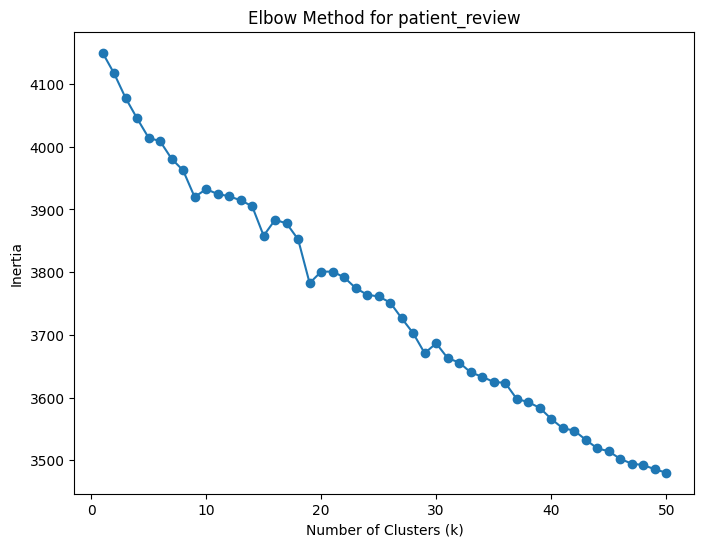

Elbow for patient_review at k =  9


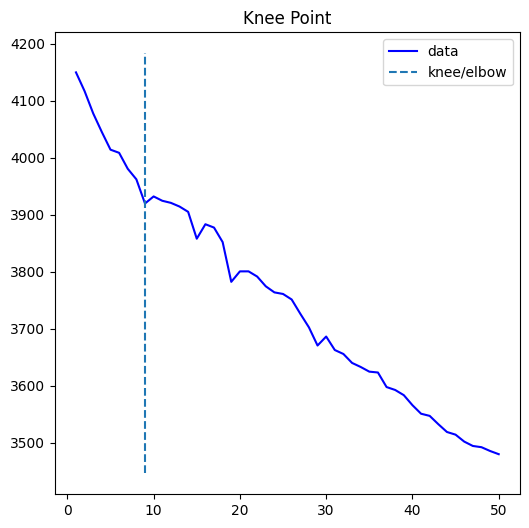

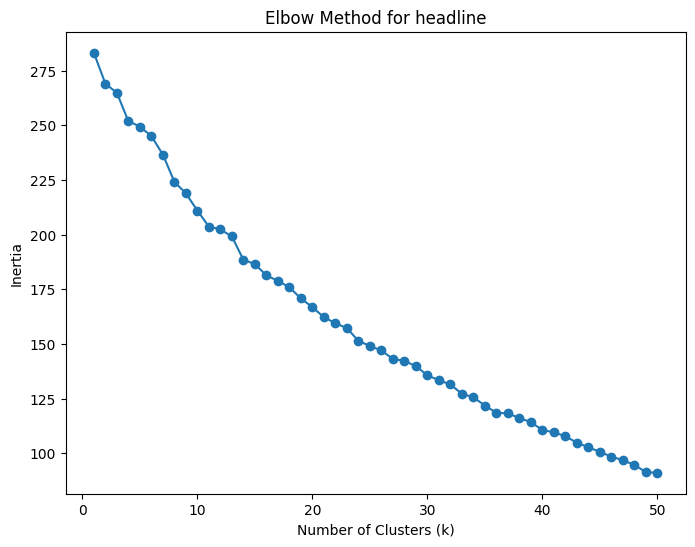

Elbow for headline at k =  27


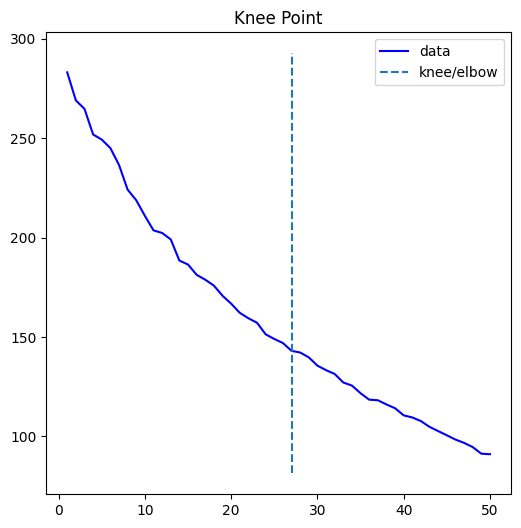

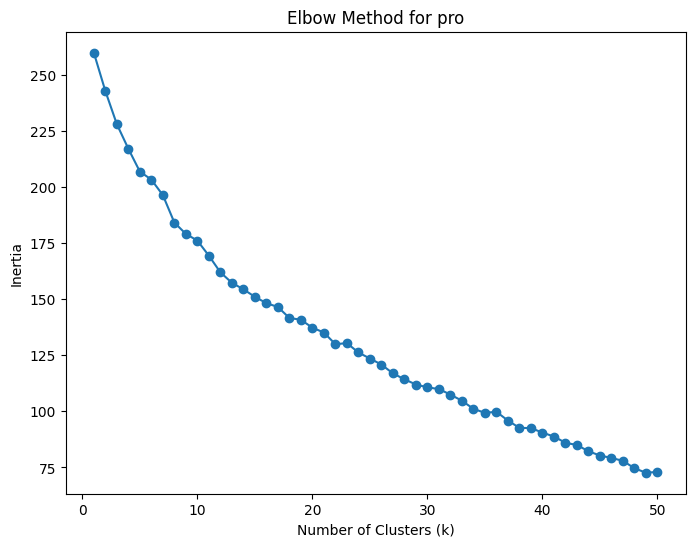

Elbow for pro at k =  13


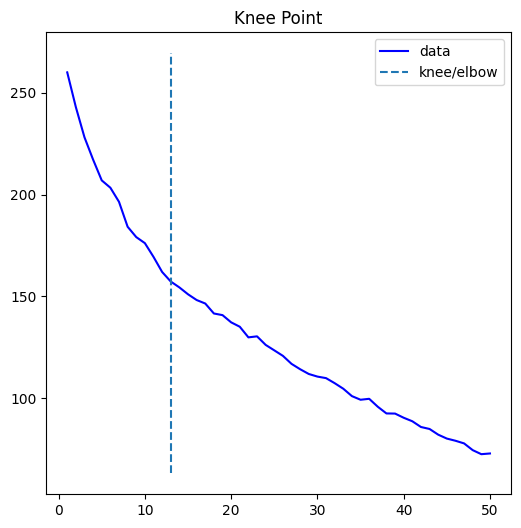

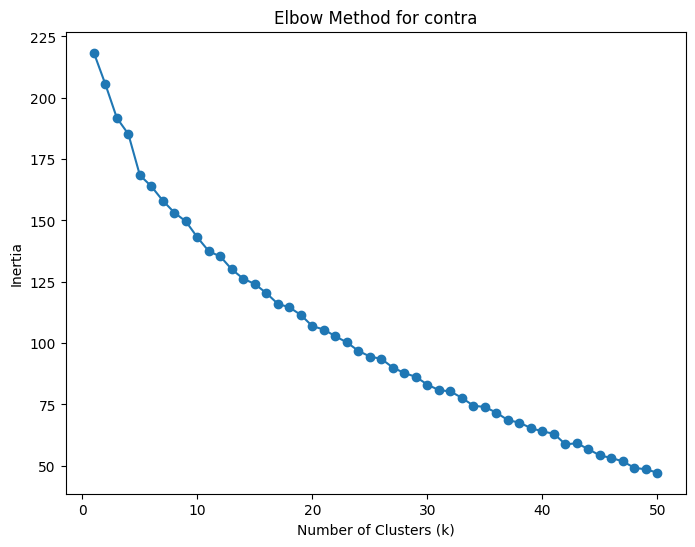

Elbow for contra at k =  20


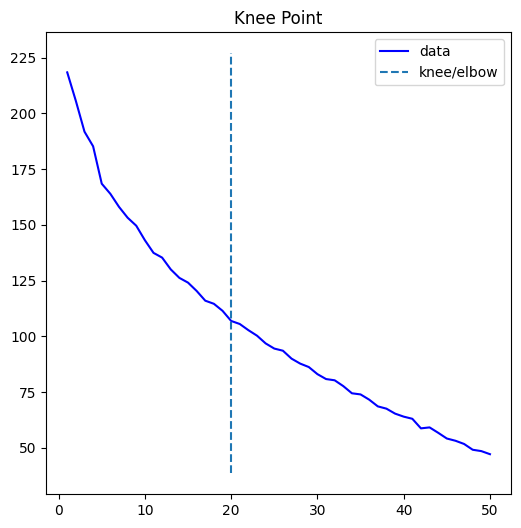

In [21]:
# testing best number of k using inertia
def test_k(dataname, df, column):
    optimal_clusters = []
    text = get_text_by_pos(df[column], ["NOUN", "PROPN"])
    # Step 1: TF-IDF Vectorization (text is already preprocessed)
    vectorizer = TfidfVectorizer(stop_words=None, max_df=0.95, min_df=2, ngram_range=(1, 2))  # Includes unigrams and bigrams
    X = vectorizer.fit_transform(text)
    
    # Step 2: Use the elbow method to determine the optimal number of clusters
    inertia = []
    testrange = range(1, 51) # Try k from 1 to 50
    for k in testrange:  
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init to supress waring
        kmeans.fit(X)
        inertia.append(kmeans.inertia_) # sum of squared distances of each data point to its closest cluster center

    # Plot the inertia for each k to find the elbow
    plt.figure(figsize=(8, 6))
    plt.plot(testrange, inertia, marker='o')
    plt.title(f'Elbow Method for {dataname}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.show()

    kl = KneeLocator(testrange, inertia, curve="convex", direction="decreasing")
    optimal_clusters.append(kl.elbow)
    print(f'Elbow for {dataname} at k = ', kl.elbow)

    # Normalized data, normalized knee, and normalized distance curve.
    # kl.plot_knee_normalized()

    # Raw data and knee.
    kl.plot_knee()

    """
    # Step 3: Apply K-Means with the optimal number of clusters
    optimal_k = int(input(f"Enter the optimal number of clusters for the column '{column}': "))
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(X)

    # Add the cluster labels to the DataFrame
    df[f'{column}_cluster'] = kmeans.labels_
    print(f"Clustering result for '{column}':")
    print(df[[column, f'{column}_cluster']].head())
    """

# Prepare a dictionary of datasets to cluster and analyze
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df
}

for dataname, dataset in datasets.items():
    test_k(dataname, dataset, "sentence")



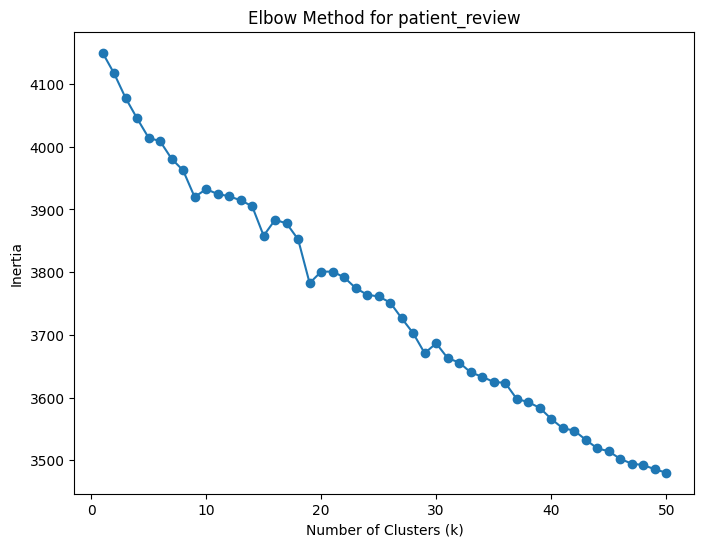

Elbow for patient_review at k =  9


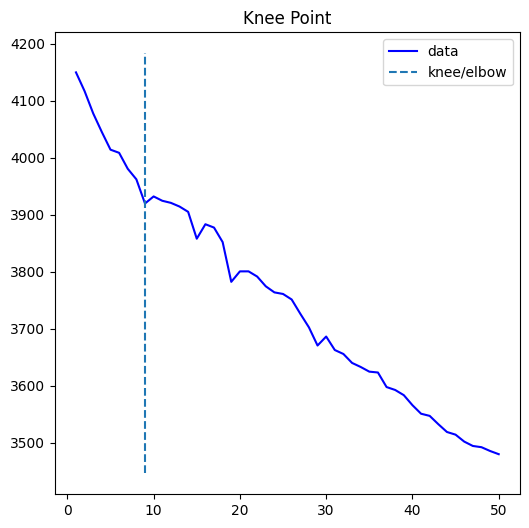

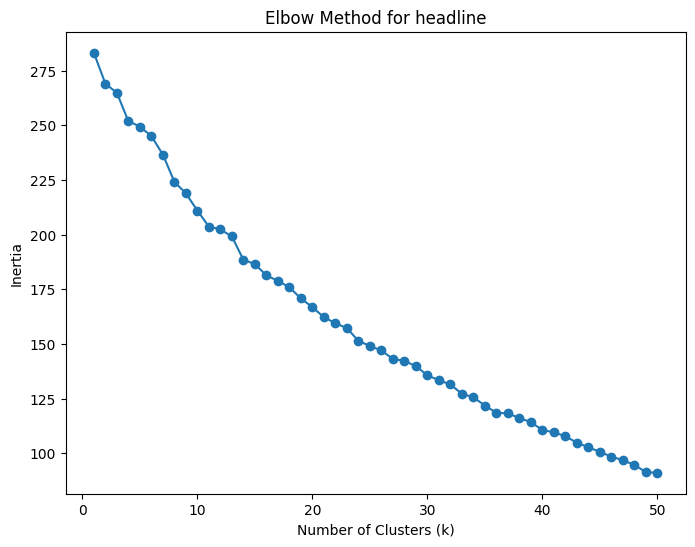

Elbow for headline at k =  27


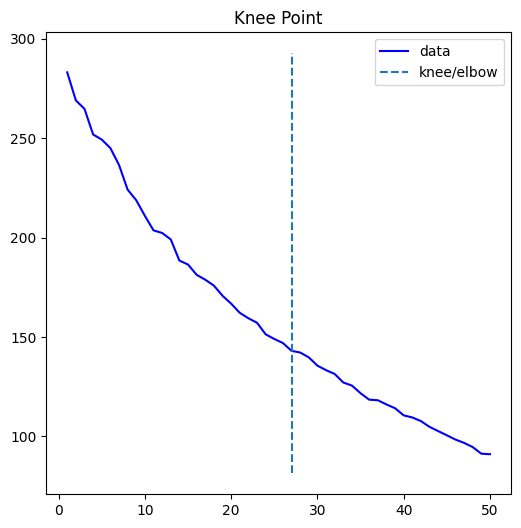

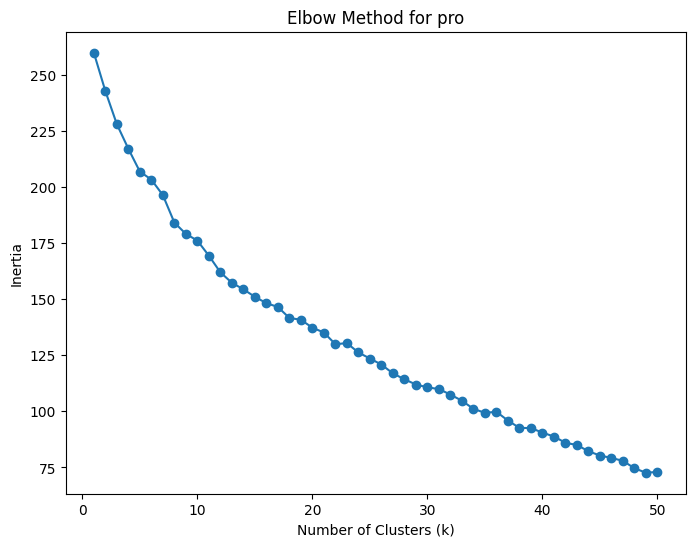

Elbow for pro at k =  13


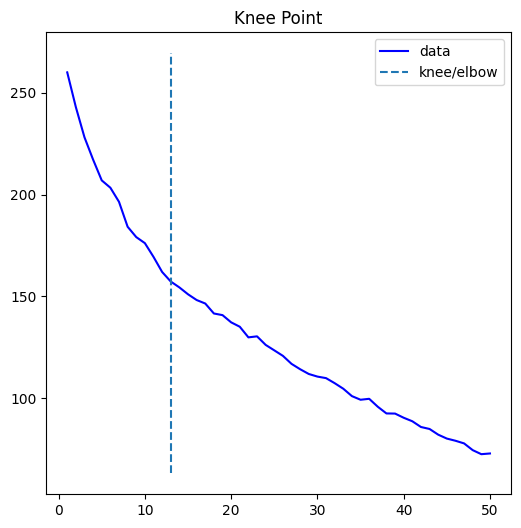

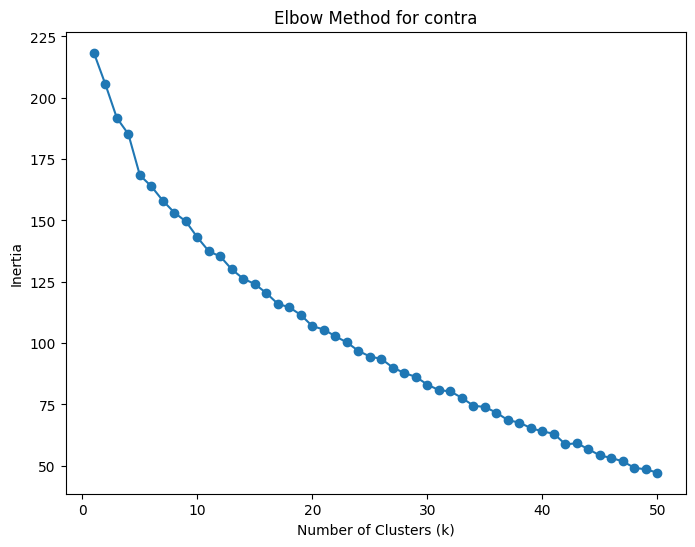

Elbow for contra at k =  20


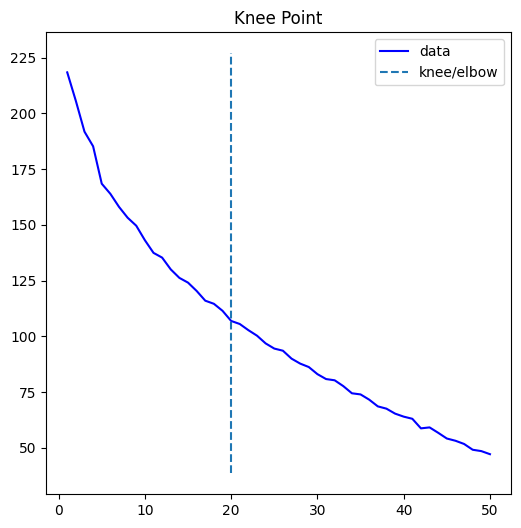

In [22]:
# test best number of k using silhouette
def test_k_silhouette(dataname, df, columns):
    optimal_k_silhouette = []
    for column in columns:
        text = get_text_by_pos(df[column], ["NOUN", "PROPN"])
        # Step 1: TF-IDF Vectorization (text is already preprocessed)
        vectorizer = TfidfVectorizer(stop_words=None, max_df=0.95, min_df=2, ngram_range=(1, 2))  # Includes unigrams and bigrams
        X = vectorizer.fit_transform(text)
        
        # Step 2: Use the elbow method to determine the optimal number of clusters
        silhouette = []
        testrange = range(2, 51) # Try k from 2 to 50 because silhouette_score() needs minimum of two clusters, or it raises exception
        for k in testrange:  
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init to supress waring
            kmeans.fit(X)
            score = silhouette_score(X, kmeans.labels_)
            silhouette.append(score) # measures similarity of data points within cluster (cohesion) compared to other clusters (separation)

        # Plot the inertia for each k to find the elbow
        plt.figure(figsize=(8, 6))
        plt.plot(testrange, silhouette, marker='o')
        plt.title(f'Elbow Method for {dataname}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette score')
        plt.show()

        kl = KneeLocator(testrange, silhouette, curve="concave", direction="increasing")
        optimal_k_silhouette.append(kl.elbow)
        print(f'Elbow for {dataname} at k = ', kl.elbow)

        # Normalized data, normalized knee, and normalized distance curve.
        # kl.plot_knee_normalized()

        # Raw data and knee.
        kl.plot_knee()

# List of the text columns to apply K-Means
# Prepare a dictionary of datasets to cluster and analyze
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df
}

for dataname, dataset in datasets.items():
    test_k(dataname, dataset, "sentence")

### Best Number of k for k-means using the elbow method Inertia and Silhouette coefficient

Inertia: Sum of squared distances of samples to their closest cluster centre.

Silhouette coefficient: measures similarity of data points within cluster (cohesion) compared to other clusters (separation)

the following tables show the best value of k using those evaluation metrics for different ranges numbers for k:

max 10 with bigrams:
|            | patient_review | headline | pro | contra |
|------------|----------------|----------|-----|--------|
| Inertia    | 9              | 4        | -   | 5      |
| Silhouette | 9              | 4        | -   | 5      | 


max 15 with bigrams:
|            | patient_review | headline | pro | contra |
|------------|----------------|----------|-----|--------|
| Inertia    | 9              | 5        | 10  | 5      |
| Silhouette | 9              | 5        | 10  | 5      |

max 20 with bigrams:
|            | patient_review | headline | pro | contra |
|------------|----------------|----------|-----|--------|
| Inertia    | 9              | 5        | 10  | 5      |
| Silhouette | 9              | 5        | 10  | 5      |

max 30 with bigrams:
|            | patient_review | headline | pro | contra |
|------------|----------------|----------|-----|--------|
| Inertia    | 9              | 5        | 13  | 5      |
| Silhouette | 9              | 5        | 13  | 5      |


max 50 with bigrams:
|            | patient_review | headline | pro | contra |
|------------|----------------|----------|-----|--------|
| Inertia    | 9              | 5        | 13  | 5      |
| Silhouette | 9              | 5        | 13  | 5      | 


Print most important terms per topic

In [23]:
def print_top_terms_for_clusters(kmeans_model, vectorizer, n_top_terms=10):
    # Get the terms from the vectorizer (feature names)
    terms = np.array(vectorizer.get_feature_names_out())
    
    # Get the cluster centers
    cluster_centers = kmeans_model.cluster_centers_
    
    # For each cluster, sort the terms by their importance (values in the cluster center)
    for i, cluster_center in enumerate(cluster_centers):
        # Get the indices of the terms sorted by their importance
        top_indices = cluster_center.argsort()[-n_top_terms:][::-1]  # Sort in descending order
        
        # Get the top terms for the current cluster
        top_terms = terms[top_indices]
        
        # Print the cluster number and the top terms
        print(f"Cluster {i+1}:")
        print(", ".join(top_terms))
        print("\n")

In [24]:
# List of columns to cluster and analyze
optimal_clusters = [9, 5, 10, 5]  # k numbers from max 15 clusters used
clusterindex = 0

# Prepare a dictionary of datasets to cluster and analyze
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df 
}

# Loop over each column to fit K-Means and print top terms
for dataname, dataset in datasets.items():
    print(f"\n--- Clustering for '{dataname}' ---\n")
    
    # Vectorize the text for the current column
    text = get_text_by_pos(dataset["sentence"], ["NOUN", "PROPN"])
    vectorizer = TfidfVectorizer(stop_words=None, max_df=0.95, min_df=2)
    X = vectorizer.fit_transform(text)
    
    # Fit K-Means model with the optimal number of clusters
    kmeans_model = KMeans(n_clusters=optimal_clusters[clusterindex], random_state=42)
    kmeans_model.fit(X)
    clusterindex +=1
    
    # Print the top terms for each cluster in this column
    print_top_terms_for_clusters(kmeans_model, vectorizer, n_top_terms=10)


--- Clustering for 'patient_review' ---

Cluster 1:
patient, tag, schwester, station, zeit, uniklinik, stunde, kind, behandlung, personal


Cluster 2:
wartezeit, stunde, patient, termin, ambulanz, beratung, organisation, schwester, ärztin, uni


Cluster 3:
operation, tag, schmerz, betreuung, personal, jahr, information, dank, op, anästhesie


Cluster 4:
klinik, uni, leipzig, patient, zeit, reha, mal, monat, tag, uniklinik


Cluster 5:
op, tag, termin, team, uhr, woche, station, stunde, arzt, komplikation


Cluster 6:
arzt, schwester, pflegepersonal, frage, zeit, patient, pfleger, tag, hebamm, station


Cluster 7:
prof, roth, dr, herr, team, op, professor, uniklinik, jahr, med


Cluster 8:
besuch, bett, rechnung, uhr, kompetent, kind, kaiserschnitt, wehen, kopf, abend


Cluster 9:
eingriff, woche, antibiose, bedenken, hautklinik, übelkeit, gehen, schritt, folge, frage



--- Clustering for 'headline' ---

Cluster 1:
behandlung, klinik, op, patient, danke, betreuung, wartezeit, uni, geb

In [25]:
# List of columns to cluster and analyze
optimal_clusters = [8, 9, 4, 8]  # k numbers from max 15 clusters used
clusterindex = 0

# Prepare a dictionary of datasets to cluster and analyze
datasets = {
    'patient_review': patient_review_df,
    'headline': headline_df,
    'pro': pro_df,
    'contra': contra_df
}

# Loop over each column to fit K-Means and print top terms
for dataname, dataset in datasets.items():
    print(f"\n--- Clustering for '{dataname}' ---\n")
    
    # Vectorize the text for the current column
    text = get_text_by_pos(dataset["sentence"], ["NOUN", "PROPN"])
    vectorizer = TfidfVectorizer(stop_words=None, max_df=0.95, min_df=2, ngram_range=(1, 2))  # Includes unigrams and bigrams
    X = vectorizer.fit_transform(text)
    
    # Fit K-Means model with the optimal number of clusters
    kmeans_model = KMeans(n_clusters=optimal_clusters[clusterindex], random_state=42)
    kmeans_model.fit(X)
    clusterindex +=1
    
    # Print the top terms for each cluster in this column
    print_top_terms_for_clusters(kmeans_model, vectorizer, n_top_terms=10)


--- Clustering for 'patient_review' ---

Cluster 1:
patient, tag, schwester, station, zeit, behandlung, personal, kind, schmerz, stunde


Cluster 2:
wartezeit, stunde, stunde wartezeit, patient, termin, wartezeit patient, wartezeit stunde, wartezeit op, beratung, organisation


Cluster 3:
operation, tag, schmerz, betreuung, operation personal, operation betreuung, personal, information, dank, jahr


Cluster 4:
klinik, uni klinik, uni, tag klinik, zeit, mal klinik, patient, welt, reha, behandlung klinik


Cluster 5:
op, tag, tag op, termin, op termin, uhr, team, op team, woche, op tag


Cluster 6:
arzt, schwester, arzt schwester, pflegepersonal, schwester arzt, arzt pflegepersonal, frage, patient, pfleger, zeit


Cluster 7:
gefühl, medikament, blutdruck, gefühl geburt, geburt, zeit gefühl, ende gefühl, nummer, haus, studie


Cluster 8:
leipzig, uniklinik leipzig, uniklinik, uni, klinik leipzig, uni leipzig, klinik, uni klinik, uniklinikum leipzig, universitätsklinikum leipzig



--- Cl

In [26]:
print(optimal_clusters[1])

9
